In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import re
#import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px
#import plotly.graph_objects as go
df1 = pd.read_csv('TMDB_movies.csv')

# Data Cleaning 

<img src = "https://plus.unsplash.com/premium_photo-1683141120496-f5921a97f5c4?q=80&w=1170&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    width = 250px 
    height = 250px/>
    
**Final number of rows after cleaning: 4797**

> examples of cleaning used
> * .drop()
> * .fillna() - flagging
> * .replace() - flagging, calculating means
> * .drop_duplicates()
>
> main jobs
> * were dropping original_title
> * converting datatypes to more suitable ones
> * extracting from dictionaries
> * calculating what to replace 0 with, using primary category to group for calculating mean

In [63]:
# check for nulls first, in case other steps need to be taken, or just note 
df1['release_date'].isnull().sum() # 1 null
df1.loc[df1['release_date'] == ''][[ 'title', 'release_date']] # 0
df1.loc[df1['release_date'] == 0 ][[ 'title', 'release_date']] # 0

# change to datetime
df1['release_date'] = pd.to_datetime(df1['release_date'], errors='coerce')
#df1.release_date.head()

# check for nulls first, just make not for future 
df1['runtime'].isnull().sum() # 2 missing
df1.loc[df1['runtime'] == ''][[ 'title', 'runtime']] #0
df1.loc[df1['runtime'] == 0 ][[ 'title', 'runtime']].count() # 35 == 0 noted, no steps to be taken yet..

# change to int 
#df1.runtime.astype('Int') # runs to error bc nulls present..

# works if i change to int64, works 
df1.runtime.astype('Int64')

df1['runtime'].isnull().sum() # still has nulls but dtype: float64 bc of NaN, still numerical tho!
#df1.runtime.head()

2

In [64]:
# step 1, call both the columns 
df1[['original_title', 'title']].head()

# step 2, find the difference using != 
df1.loc[df1['original_title'] != df1['title']][['original_title', 'title']] #261 rows where they dont match .. 

# step 3, decision .. 'original_title' will be dropped bc it has non english chars and less consistent 
df1.drop(columns = ['original_title'],inplace = True) # dropped !

In [65]:
df1_nonulls = df1.copy() #make a df copy
df1_nonulls['homepage'] = df1_nonulls['homepage'].fillna('X') # flag nulls in homepage
df1_nonulls['tagline'] = df1_nonulls['tagline'].fillna('X') # flag nulls in tagline
df1_nonulls['overview'] = df1_nonulls['overview'].fillna('X') #flag nulls for overview

#df1_nonulls.isnull().sum() # nice, homepage, tagline, and overview dealt with, for now..

#drop nulls here, only a small percentage lost
df1_nonulls.dropna (
    axis = 0, 
    how = 'any',
    subset = ['runtime', 'release_date'], 
    inplace = True)

#df1_nonulls.shape # now 4800 columns !!

In [66]:
import ast
ast.literal_eval(df1_nonulls.genres[0])[0]['name']

def extract_genres(x):            #function for extracting the genres
    x = ast.literal_eval(x)       # conv to obj list
    Genres = []                   # store the genres
    
    for item in x:                # iterate for each dictionary in our list
        Genres.append(item['name']) # Grab the 'name' key for each dictionary
        
    return Genres                  # this will be a list of all the genres

# apply to genres
df1_nonulls['extracted_genres'] = df1_nonulls['genres'].apply(extract_genres)

def extract_list_1(x):            #function for extracting the genres
    x = ast.literal_eval(x)       # conv to obj list
    extracted = []                   # store the genres
    
    for item in x:                # iterate for each dictionary in our list
        extracted.append(item['name']) # Grab the 'name' key for each dictionary
        
    return extracted                  # this will be a list of all the genres

# apply to column
df1_nonulls['extracted_keywords'] = df1_nonulls['keywords'].apply(extract_list_1)
#df1_nonulls.head()  

df1_nonulls['extracted_prodcomp'] = df1_nonulls['production_companies'].apply(extract_list_1) #extract prduction companies
df1_nonulls['extracted_prodcountries'] = df1_nonulls['production_countries'].apply(extract_list_1) #extract countries
df1_nonulls['extracted_spoken'] = df1_nonulls['spoken_languages'].apply(extract_list_1)
#df1_nonulls.head()


In [67]:
#drop cols extracted from
df1_nonulls_dropped = df1_nonulls.copy()

df1_nonulls_dropped = df1_nonulls_dropped.drop(columns = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages'])

In [68]:
# dealing witht he 0 values
df2 = df1_nonulls_dropped.copy()

# dealing w budget
#extract the main genre from the list
df2['primary_genre'] = df2['extracted_genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
# replace 0 with mean of its main cat 
df2['budget'] = df2.groupby('primary_genre')['budget'].transform(lambda x: x.replace(0, x.mean()))
#df2[df2['budget'] == 0]

#dealing w 0 popularity
df2['popularity'] = df2.groupby('primary_genre')['popularity'].transform(lambda x: x.replace(0, x.mean()))
#df2[df2['popularity'] == 0]


#dealing w 0 revenue
df2['revenue'] = df2['revenue'].mask(
    (df2['revenue'] == 0) | (df2['revenue'].isna()),
    df2.groupby('primary_genre')['revenue'].transform(lambda x: x[x != 0].mean())
)

#also need to apply to NaN

#df2[df2['revenue'] == 0.0]
#df2.groupby('primary_genre')['revenue'].sum()
#df2[df2['primary_genre'] == 'TV Movie'] # no mean to be calculated .. 

#dealing w 0 runtime
df2['runtime'] = df2.groupby('primary_genre')['runtime'].transform(
    lambda x: x.replace(0.0, x[x != 0.0].mean()))
#df2[df2['runtime'] == 0.0]


#dealing w 0 vote_average 
df2['vote_average'] = df2.groupby('primary_genre')['vote_average'].transform(lambda x: x.replace(0, x.mean()))
#df2[df2['vote_average'] == 0]

#dealing w 0 vote_count 
df2['vote_count'] = df2.groupby('primary_genre')['vote_count'].transform(lambda x: x.replace(0, x.mean()))
#df2[df2['vote_count'] == 0]



In [69]:
# make sure there are no duplicate titles
unique_title = set(df2.title)
#len(unique_title) #4797 vs 4800 originally

titles = set(df2.title)
strip_title = {t.strip().lower() for t in titles}
#len(strip_title) # same as the top

df2_unique = df2[df2['title'].str.strip().str.lower().isin(strip_title)].drop_duplicates(subset='title')
#df2_unique.shape


# EDA - Exploring the data set

<img src = "https://images.unsplash.com/photo-1682687220742-aba13b6e50ba?q=80&w=1170&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    width = 400px 
    height = 400px/>

Now that we have sorted the nulls out, let's explore the data !



## Which genres make the highest revenue ?
* now consider the budget
* profit, which genre is a safer investment?

In [70]:
#make df
df2_unique.describe()
df = df2_unique.copy()

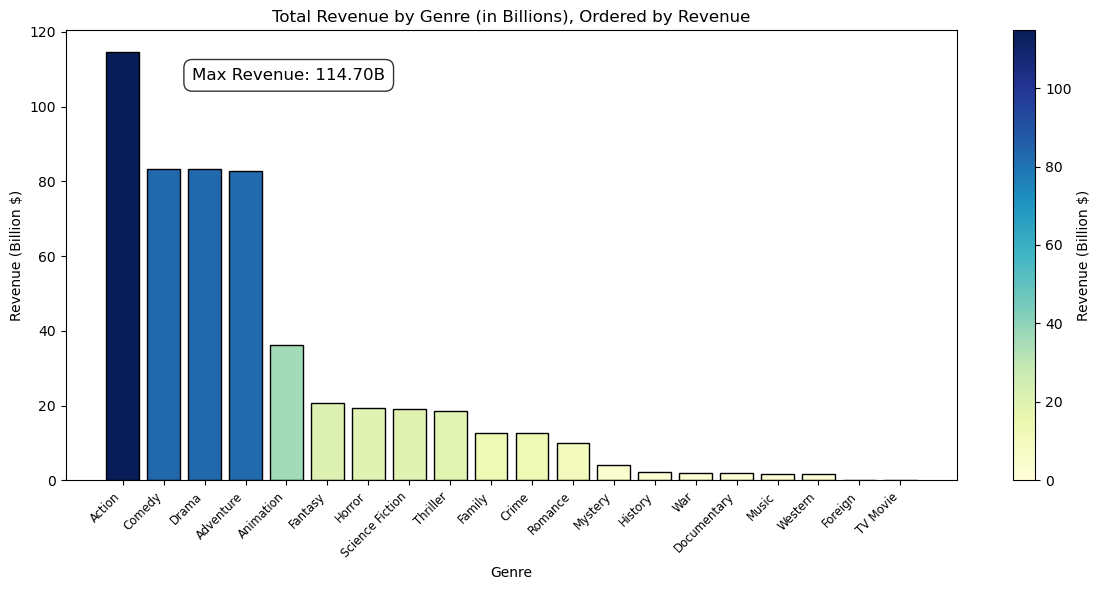

In [71]:
# make the plot !

import matplotlib.colors as colors
import matplotlib.cm as cm

# sum revenue by genre and convert to billions
genre_revenue = df2.groupby('primary_genre')['revenue'].sum() / 1e9

# sort rev by desc
genre_revenue_sorted = genre_revenue.sort_values(ascending=False)

# normalise for colormap
norm = colors.Normalize(vmin=genre_revenue_sorted.min(), vmax=genre_revenue_sorted.max())
cmap = cm.YlGnBu

# create the figure
fig, ax = plt.subplots(figsize=(12, 6)) # create the figure
bars = ax.bar(genre_revenue_sorted.index, genre_revenue_sorted.values, edgecolor='black') # add the bars by the sorted value

# set colour to bar value
for i, bar in enumerate(bars):
    color = cmap(norm(genre_revenue_sorted.values[i]))
    bar.set_facecolor(color)

# customise axis and labels
ax.set_title('Total Revenue by Genre (in Billions), Ordered by Revenue')
ax.set_xlabel('Genre')
ax.set_ylabel('Revenue (Billion $)')
plt.xticks(rotation=45, ha='right', fontweight = 'light',
           fontsize = 'small')

# add legend
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Revenue (Billion $)')

# find max revenue and its index, to put in label box
max_revenue = genre_revenue_sorted.max()
max_index = genre_revenue_sorted.idxmax()
max_pos = list(genre_revenue_sorted.index).index(max_index)

# label max
ax.text(
    0.25, 0.9,  # (x, y) position the box, adjust as needed
    f'Max Revenue: {max_revenue:.2f}B',
    ha='center', va='center',
    fontsize=12,
    fontweight='light',
    color='black',
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    ,
    transform=ax.transAxes  # Use axes coords, not data coords
)

plt.tight_layout()
plt.show()

reference for [box label](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html)\
reference for [mapping colour to values](https://matplotlib.org/stable/api/cm_api.html)

## Focus on top 10 primary genres, looking at budget vs revenue vs profit

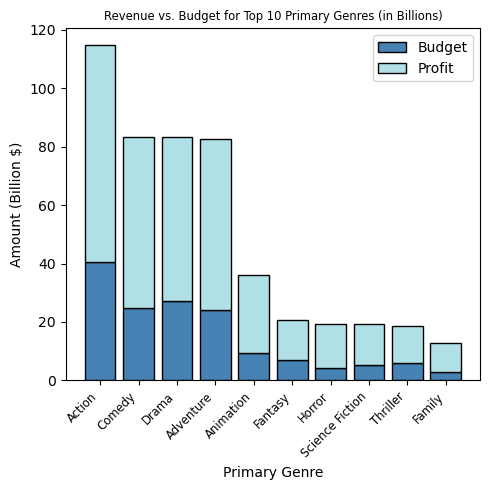

In [102]:
# Group by primary_genre, sum revenue and budget
genre_finances = df2.groupby('primary_genre')[['revenue', 'budget']].sum()

# Convert to billions for readability
genre_finances = genre_finances / 1e9

# Get top 10 genres by revenue
top10 = genre_finances.sort_values('revenue', ascending=False).head(10)

# Plot stacked bars
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(top10.index, top10['budget'], label='Budget', color='steelblue', edgecolor='black')
ax.bar(top10.index, top10['revenue'] - top10['budget'], bottom=top10['budget'],
       label='Profit', color='powderblue', edgecolor='black')

# Labels and formatting
ax.set_title('Revenue vs. Budget for Top 10 Primary Genres (in Billions)', fontsize='small')
ax.set_ylabel('Amount (Billion $)')
ax.set_xlabel('Primary Genre')
plt.xticks(rotation=45, ha='right', fontsize='small')
ax.legend()

plt.tight_layout()
plt.show()

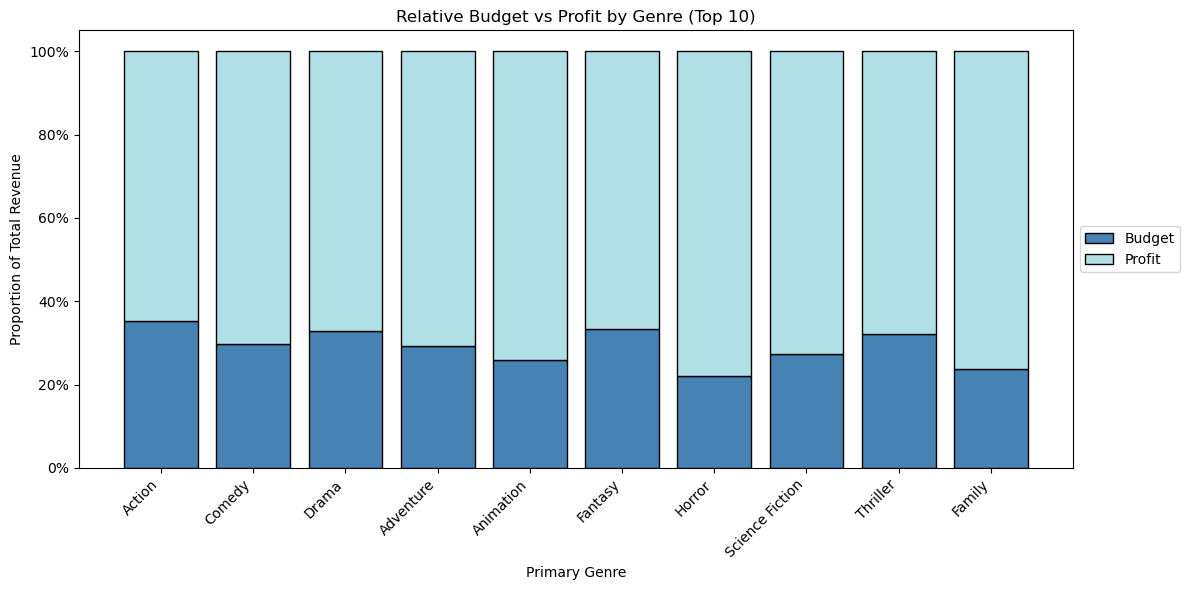

In [113]:
#group and sum revenue & budget
genre_finances = df2.groupby('primary_genre')[['revenue', 'budget']].sum()

# top10 genres only
top10 = genre_finances.sort_values('revenue', ascending=False).head(10)

# calc profit, new column
top10['profit'] = top10['revenue'] - top10['budget']

# calc percentage rev vs budget
top10['budget_pct'] = top10['budget'] / top10['revenue']
top10['profit_pct'] = top10['profit'] / top10['revenue']


# stacked bar chart, using pct for better comparison of spend
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(top10.index, top10['budget_pct'], #budget bar
       label='Budget', color='steelblue', edgecolor='black')
ax.bar(top10.index, top10['profit_pct'], bottom=top10['budget_pct'], #profit bar, budget below
       label='Profit', color='powderblue', edgecolor='black')

ax.set_title('Relative Budget vs Profit by Genre (Top 10)')
ax.set_ylabel('Proportion of Total Revenue')
ax.set_xlabel('Primary Genre')
plt.xticks(rotation=45, ha='right')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # on the side

# format y as %
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

#df['budget'].max()

## 🎬 Genre-wise Budget and Profit Insights
Very impressive numbers from action, but lets look at the percentage profit for a better understanding

#### Action 
- big spend = big return but relative profit margin not that much greater

#### Fantasy 
- not in top 5 but seems to have asimilar spend as action

#### Horror
- lowest budget with decent relative profit >> suggesting better returns\
    **- recommend exploring the horror genre if company is looking for more bang for your buck**



ref for [stacked bar chart](https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html)

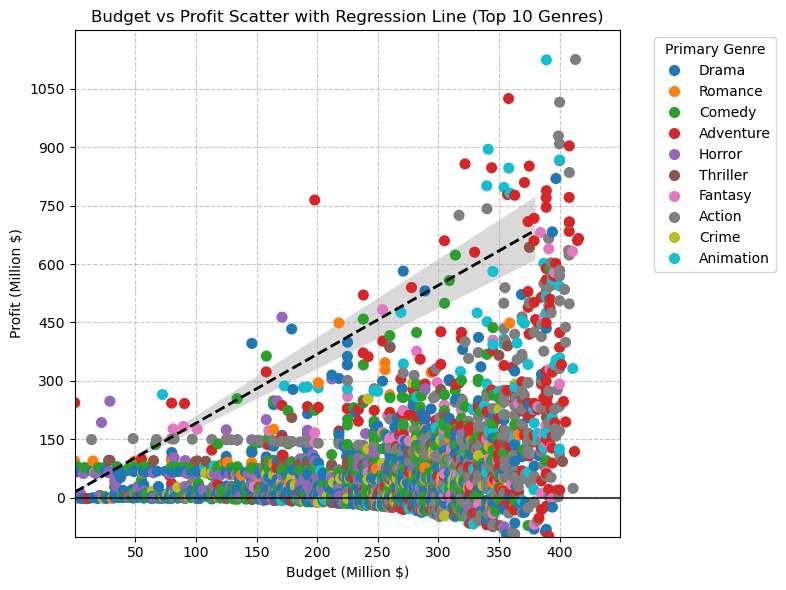

In [101]:
from matplotlib.ticker import MaxNLocator, ScalarFormatter
# new cols calculated
df['budget_million'] = df['budget'] / 1e6 # convert to mil
df['profit_million'] = (df['revenue'] - df['budget']) / 1e6

# top 10 genres
top_10_genres = df['primary_genre'].value_counts().nlargest(10).index

# filter for top10
df_top10 = df[df['primary_genre'].isin(top_10_genres)]

plt.figure(figsize=(8, 6))

# strip plot for top 10 genres only
sns.stripplot(data=df_top10, x='budget_million', y='profit_million',
              size=8, hue='primary_genre', jitter=True, zorder=2) # zorder for visibility

# regression line overall
sns.regplot(data=df_top10, x='budget_million', y='profit_million',
            scatter=False,
            color='black',
            line_kws={'linewidth': 2, 'linestyle': '--'})

# custom the axis + titles
plt.title('Budget vs Profit Scatter with Regression Line (Top 10 Genres)')
plt.xlabel('Budget (Million $)')
plt.ylabel('Profit (Million $)')

#set limits
ax = plt.gca()
ax.set_xlim(0, 450)      
ax.set_ylim(-100, 1200)

# set the xticks, use maxlocator to do bins
ax.xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both', integer=True))
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.xaxis.get_major_formatter().set_scientific(False)

# set the yticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=10, prune='both', integer=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.yaxis.get_major_formatter().set_scientific(False)

#add zero line, better vis
ax.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
#add grid for better vis
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.legend(title='Primary Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 🎬 Budget vs Profit Analysis by Genre

You can see a positive relationship between budget and profit here, clearly illustrated by the regression line.\
General trend is more money spent = more money earned $$$

### Genre insights:
> 🔴 Adventure (Red)
> * Exhibits the most variance in and profit. high risk

> 
>🟢 Comedy (Green) and 🔵 Drama (Blue)
> * Tend to be lower risk but still turn profits.
> * Dramas appear riskier than comedies, given the number of negative profit occurrences, especially at larger budgets.

ref for [maxlocator and scalarformatter](https://matplotlib.org/stable/api/ticker_api.html)

## Key take aways

<img src = "https://plus.unsplash.com/premium_photo-1707146617695-884c18a3fcff?q=80&w=1170&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    width = 200px 
    height = 200px/>
    
- big budget = big profit .. usually - it's a high risk, high reward game
- adventure shows the most variance in terms of profit, they lean more towards big budgets .. high risk, high reward
- comedies may be a lower risk option to ensure return of profit
- dramas are similar but are riskier than comedies
- horrors are lower budget and return a a good proportion of profit

## **Recommendations**
- **Consider expanding into horrors and comedies**
    * Horrors - better ROI
    * Comedies - safer midbudget option
- **Actions are risky but have the highest profit sum, indicating popularity with movie watchers**
    * Consider calculated risks with Action movies

ref for [regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html)

# Let's explore runtime 🏃🏽‍♀️‍➡️⏳


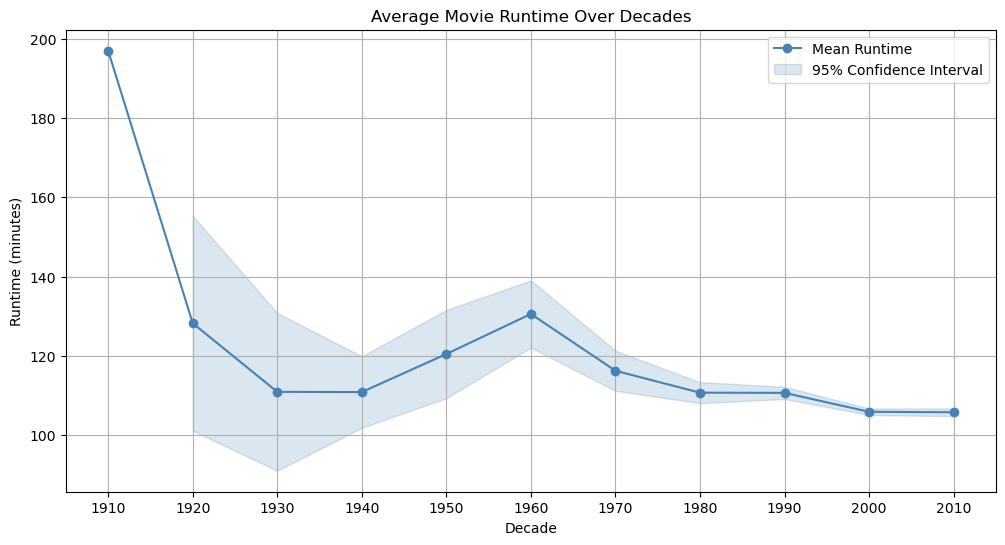

In [94]:

# create 'decade' column (e.g., 1950, 1960...)
df['year'] = df['release_date'].dt.year

df['decade'] = (df['year'] // 10) * 10  # floor to decade start, e.g. 1994 -> 1990

# group by decade and calc mean runtime and std dev (for variability)
decade_stats = df.groupby('decade')['runtime'].agg(['mean', 'std', 'count']).reset_index()

# calculate confidence interval for shading
decade_stats['ci95'] = 1.96 * (decade_stats['std'] / np.sqrt(decade_stats['count']))

# plot
plt.figure(figsize=(12,6))
plt.plot(decade_stats['decade'], decade_stats['mean'], marker='o', label='Mean Runtime', color='steelblue')
plt.fill_between(
    decade_stats['decade'],
    decade_stats['mean'] - decade_stats['ci95'], #shading both sides
    decade_stats['mean'] + decade_stats['ci95'],
    color='steelblue', alpha=0.2, label='95% Confidence Interval'
)
# custom the labels and that 
plt.title('Average Movie Runtime Over Decades')
plt.xlabel('Decade')
plt.ylabel('Runtime (minutes)')
plt.xticks(decade_stats['decade'])
plt.legend()
plt.grid(True)
plt.show()

ref for [confidence interval](https://www.pythoncharts.com/python/line-chart-with-confidence-interval/)

- We can see that as the decades pass, movies have tended to have more uniform runtimes, compared to older movies
- From the beginning of the data, runtime decreased until 1930, then increased again until 1960, where it seemes to be reaching the beginning of a plateau with tight confidence intervals suggesting there is more recent data vs pre 1960


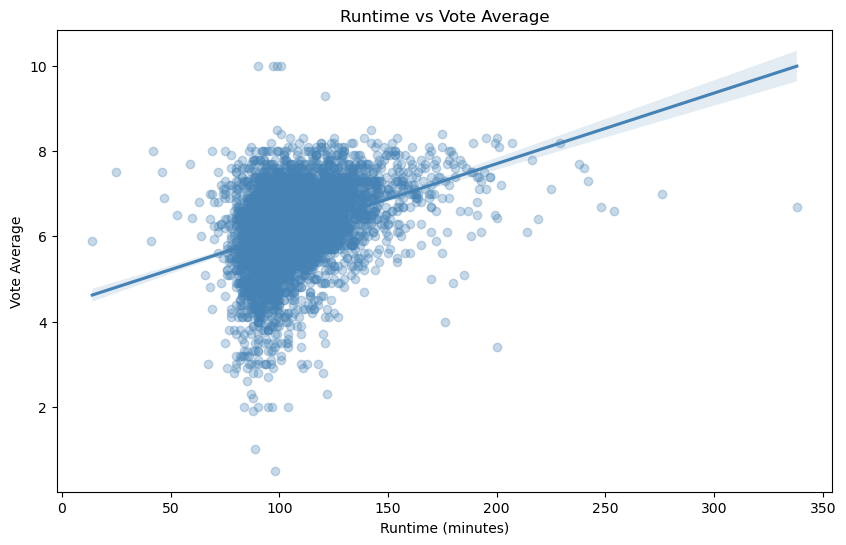

In [112]:
# set size
plt.figure(figsize=(10, 6))

# regplot - w line
sns.regplot(data=df, x='runtime', y='vote_average', scatter_kws={'alpha':0.3}, color='steelblue') 

# label custom
plt.title('Runtime vs Vote Average')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Vote Average')
plt.show()

  
### Key take aways

<img src = "https://images.unsplash.com/photo-1608170825938-a8ea0305d46c?q=80&w=1025&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    width = 300px 
    height = 300px/>

* Runtimes have decreased over time
* Runtimes have become more uniform in recent decades
* Although there is a positive relationship between runtime and vote average, there seems to be a cluster of runtimes around the 120min mark
  
**Recommendation: consider longer runtimes..** great success recently with The Irishman 209mins!!
* Possibly missing out on opportunity to secure higher vote averages, public opinion can drive the success or failure of a movie
* Make bold choices, give time for narratives to develop

# A tale of two movies 

Let's look closer at two movies .. 

<img src = "https://images.unsplash.com/photo-1586769852836-bc069f19e1b6?q=80&w=1170&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    width = 400px 
    height = 400px/>

### Choosing the movies:
Based on our previous exploration, I wanted to compare two movies which either had the **highest vote average** or **highest profit**
> * filtered budget for at least $1,000,000
> * filtered for vote count at least 50

In [77]:
# Filter for budget > 1,000,000 and vote_count > 50
df_filtered = df[(df['budget'] > 1_000_000) & (df['vote_count'] > 50)].copy()

# Calculate profit margin
df_filtered['profit'] = (df_filtered['revenue'] - df_filtered['budget'])

# Find movie with highest profit margin
best_profit_movie = df_filtered.loc[df_filtered['profit'].idxmax()]

# Find movie with highest rating (vote_average)
best_rated_movie = df_filtered.loc[df_filtered['vote_average'].idxmax()]

# Display summary comparison
#print("Best Profit Margin Movie:")
#print(f"Title: {best_profit_movie['title']}")
#print(f"Profit: ${best_profit_movie['profit']:,.0f}")
#print(f"Revenue: ${best_profit_movie['revenue']:,}")
#print(f"Budget: ${best_profit_movie['budget']:,}")
#print(f"Vote Average: {best_profit_movie['vote_average']}")
#print(f"Vote Count: {best_profit_movie['vote_count']}")
#print(f"Runtime: {best_profit_movie['runtime']} mins\n")

#print("Highest Rated Movie:")
#print(f"Title: {best_rated_movie['title']}")
#print(f"Vote Average: {best_rated_movie['vote_average']}")
#print(f"Vote Count: {best_rated_movie['vote_count']}")
#print(f"Revenue: ${best_rated_movie['revenue']:,}")
#print(f"Budget: ${best_rated_movie['budget']:,}")
#rint(f"Profit: ${best_rated_movie['profit']:,.0f}")
#print(f"Runtime: {best_rated_movie['runtime']} mins")

**Best Profit Margin Movie:**\
**Title:** Avatar\
**Profit:** \$2,550,965,087  
**Revenue:** \$2,787,965,087  
**Budget:** \$237,000,000  
**Vote Average:** 7.2  
**Vote Count:** 11,800  
**Runtime:** 162 mins  

---

**Highest Rated Movie:**  
**Title:** The Shawshank Redemption  
**Vote Average:** 8.5  
**Vote Count:** 8,205  
**Revenue:** \$28,341,469  
**Budget:** \$25,000,000  
**Profit:** \$3,341,469  
**Runtime:** 142 mins  

In [91]:
#df[(df['title'] == 'The Shawshank Redemption') | (df['title'] == 'Avatar')]

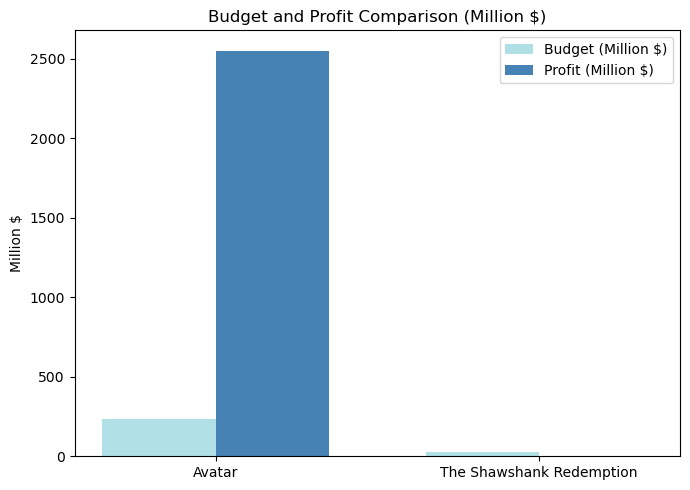

/var/folders/4c/r194bw897p17wysf_9j_30y00000gn/T/ipykernel_1594/3491929057.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=compare_votes, x='title', y='vote_average', palette='Blues')


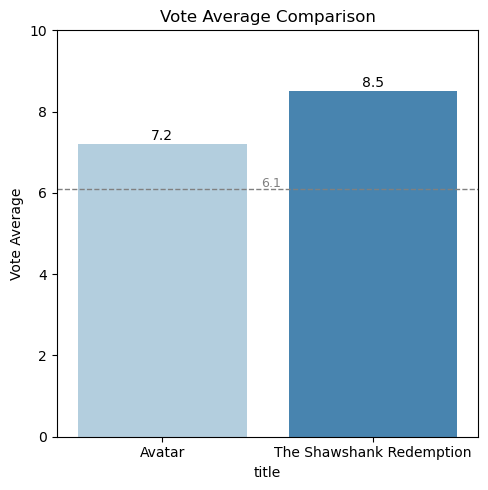

In [111]:
# table 1- budget profit comp
# make dataframe
df_compare = pd.DataFrame({
    'title': [best_profit_movie['title'], best_rated_movie['title']],
    'budget_million': [best_profit_movie['budget'] / 1e6, best_rated_movie['budget'] / 1e6],
    'profit_million': [(best_profit_movie['revenue'] - best_profit_movie['budget']) / 1e6,
                       (best_rated_movie['revenue'] - best_rated_movie['budget']) / 1e6]
})

x = np.arange(len(df_compare['title']))  # the label locations
width = 0.35  # width of the bars

plt.figure(figsize=(7,5))

# budget bars
plt.bar(x - width/2, df_compare['budget_million'], width, label='Budget (Million $)', color='powderblue')
# profit bars
plt.bar(x + width/2, df_compare['profit_million'], width, label='Profit (Million $)', color='steelblue')

# custom labels
plt.ylabel('Million $')
plt.title('Budget and Profit Comparison (Million $)')
plt.xticks(ticks=x, labels=df_compare['title'], rotation=0)
plt.legend()
plt.tight_layout()
plt.show()


# table 2 - vote avergae comparison
# new df to compare
compare_votes = pd.DataFrame({
    'title': [best_profit_movie['title'], best_rated_movie['title']],
    'vote_average': [best_profit_movie['vote_average'], best_rated_movie['vote_average']]
})

# plot fig
plt.figure(figsize=(5, 5))
sns.barplot(data=compare_votes, x='title', y='vote_average', palette='Blues')

# values label
for i, row in compare_votes.iterrows():
    plt.text(i, row['vote_average'] + 0.1, f"{row['vote_average']:.1f}", ha='center')

# average vote
plt.axhline(y=6.1, color='gray', linestyle='--', linewidth=1)
plt.text(0.47, 6.15, '6.1', color='gray', fontsize=9)

#custom labels
plt.title('Vote Average Comparison')
plt.ylabel('Vote Average')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()  

Despite having a higher vote average amongst viewers
> * Vote Average for **'Avatar': 7.2**
> * Vote Average for **'The Shawshank Redemption': 8.5**


We can see here that Avatar absolutely swamps The Shawshank Redemption in both profit and budget
> can avatar be considered an outlier - crazy numbers !!
> * Percentage Profit Return for **'Avatar': 1076.36%**
> * Percentage Profit Return for **'The Shawshank Redemption': 13.37%**


<img src = "https://images.unsplash.com/photo-1429743305873-d4065c15f93e?q=80&w=1167&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    width = 400px 
    height = 400px/>
    
### That leads us to an interesting fork in the road..
- to pursue profit margins ?\
  or
-  to pursue higher vote averages?



> Avatar had a huge budget but still managed to pull in a strong rating of 7.2, which is way above the average of 6.1 across all movies in the data set.
> * proving not all blockbusters are critical flops
> 
> On the flip side, The Shawshank Redemption proves you don’t need a massive budget to secure great ratings (8.5)
> * budget is NOT a limitation for great ratings

## Recommendations:
- Secure a big budget for your movie :)
- Use that budget as effectively as The Shawshank Redemption
    - Result = secret to success 💸
 
Look more closely into what made Avatar and The Shawshank Redemption successes.

#  

In [30]:
#f[df['budget'] == df['budget'].max()][['title', 'budget', 'primary_genre']]

In [31]:
profit_return_best_profit = ((best_profit_movie['revenue'] - best_profit_movie['budget']) / best_profit_movie['budget']) * 100

# Calculate percentage profit return for highest rated movie
profit_return_best_rated = ((best_rated_movie['revenue'] - best_rated_movie['budget']) / best_rated_movie['budget']) * 100

#print(f"Percentage Profit Return for '{best_profit_movie['title']}': {profit_return_best_profit:.2f}%")
#print(f"Percentage Profit Return for '{best_rated_movie['title']}': {profit_return_best_rated:.2f}%")

In [32]:
#print(f"Vote Average for '{best_profit_movie['title']}': {best_profit_movie['vote_average']}")
#print(f"Vote Average for '{best_rated_movie['title']}': {best_rated_movie['vote_average']}")

In [80]:
#df['budget'].mean()